# Preliminary simulation

## Generating the X's

In [2]:
N <- 10000
delta <- rnorm(N)
omega <- runif(N)
phi <- runif(N)
funs <- vector("list", N)
fun <- function(omega_i, phi_i, t) {
  sin(2*pi*(omega_i * t + phi_i))
}


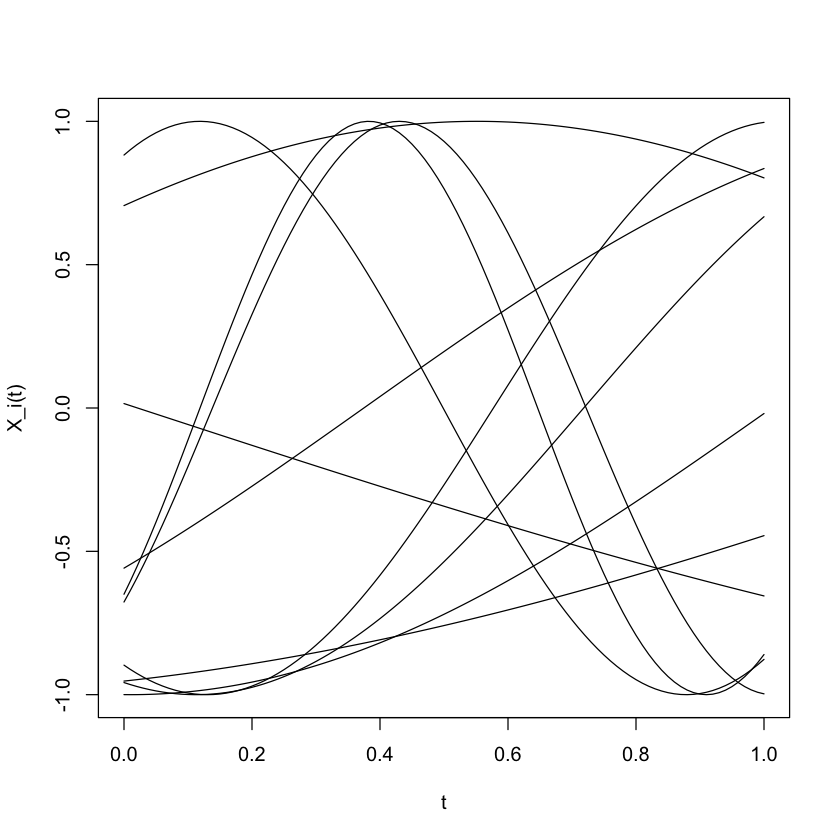

In [4]:

curve(fun(omega[1], phi[1], x), from = 0, to = 1, ylim = c(-1, 1), ylab = "X_i(t)", xlab = "t")
for(i in 2:10){
    curve(fun(omega[i], phi[i], x), add = TRUE)
}



## Generating the Y's

In [5]:
Z <- rnorm(N)
beta_0 <- 0
beta_z <- 1
beta_1 <- function(t) cos(2*pi*t)
eta_0 <- 0
eta_z <- -.1
eta_1 <- function(t) .1*cos(2*pi*(t + 1/8))

In [6]:
Y <- vector("numeric", N)
for(i in 1:N){
    integrand_1 <- function(t) fun(omega[i], phi[i], t)*beta_1(t)
    integrand_2 <- function(t) fun(omega[i], phi[i], t)*eta_1(t)
    integral_1 <- integrate(integrand_1, 0, 1)$value
    integral_2 <- integrate(integrand_2, 0, 1)$value
    Y[i] <- beta_0 + beta_z*Z[i] + integral_1 + exp(eta_0 + eta_z*Z[i] + integral_2)*delta[i]
}

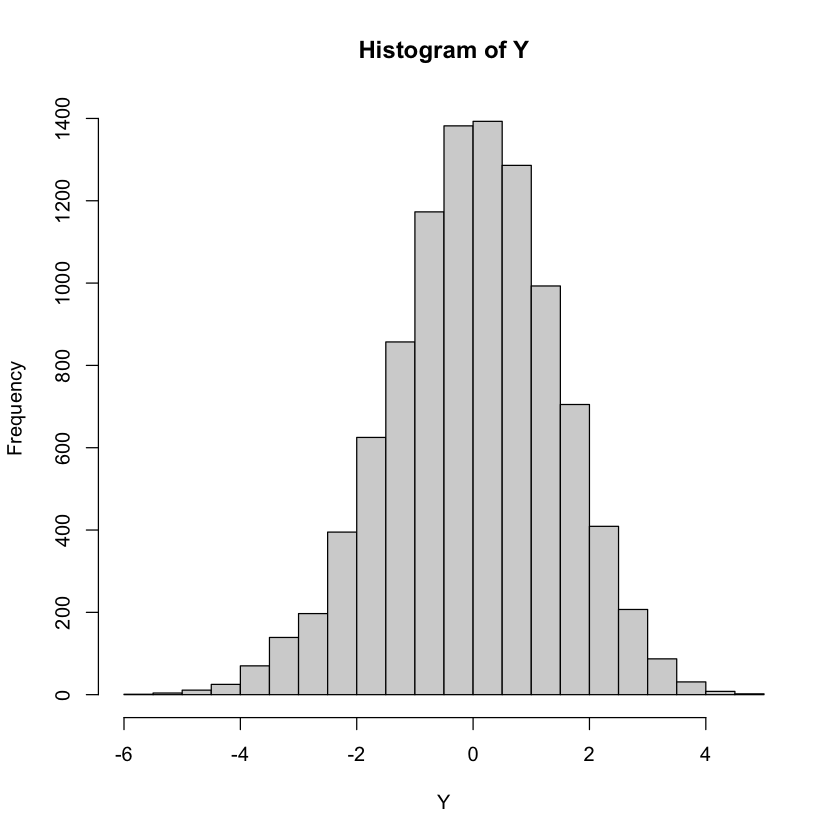

In [7]:
hist(Y, breaks = 20, main = "Histogram of Y", xlab = "Y", ylab = "Frequency")

## Basis Expansion

In [8]:
library(splines)
x <- seq(0, 1, length.out = 100)
basis <- bs(x, 10, degree = 3, intercept = TRUE)
dim(basis)

[1] 100  10

In [9]:
coefs <- matrix(0, nrow = N, ncol = 10)
for(i in 1:N){
    y <- fun(omega[i], phi[i], x)
    fit <- lm(y ~ basis -1)
    coefs[i, ] <- fit$coefficients
}
coefs[1:5, ]

[,1]       [,2]       [,3]       [,4]       [,5]        [,6]      
[1,] -0.6493114 -0.4357670  0.1618319  0.9464597  1.08681291  0.4870554
[2,]  0.8823940  0.9753458  1.0544842  0.8169553  0.30248469 -0.3141613
[3,] -0.5585946 -0.4961328 -0.3616491 -0.1415489  0.08575033  0.3086879
[4,] -0.9998656 -1.0010960 -0.9867414 -0.9159263 -0.79934529 -0.6428315
[5,]  0.7060596  0.7541463  0.8405091  0.9353054  0.99142462  1.0065494
     [,7]       [,8]       [,9]        [,10]      
[1,] -0.4450126 -1.0726280 -1.00628486 -0.85998461
[2,] -0.8246784 -1.0556400 -0.97186044 -0.87691923
[3,]  0.5159376  0.6969560  0.79402518  0.83541108
[4,] -0.4542002 -0.2428773 -0.09390602 -0.01925877
[5,]  0.9800545  0.9130318  0.84318623  0.80268678

## Fitting the model

In [10]:
library(brms)

GamF <- function(gam, p0) {
    (2 * pnorm(-abs(gam)) * exp(.5 * gam^2) - p0)^2
}

# optimize(GamF,interval = c(-30,30), p0=1 - 0.05)
GamBnd <- function(p0) {
    Re1 <- optimize(GamF, interval = c(-30, 30), p0 = 1 - p0)
    Re2 <- optimize(GamF, interval = c(-30, 30), p0 = p0)

    c(-abs(Re1$minimum), abs(Re2$minimum), Re1$objective, Re2$objective)
}
GamBnd <- Vectorize(GamBnd, "p0")

tau0 <- .25


Bd <- GamBnd(tau0)[1:2]

GAL2 <- custom_family(
    "GAL2",
    dpars = c("mu", "sigma", "ligam", "tau"), links = c("identity", "log", "identity", "identity"),
    lb = c(NA, 0, Bd[1] * .99, 0), ub = c(NA, NA, Bd[2] * .99, 1), type = "real"
) # , vars = "vint1[n]"


stan_funs2 <- "
    /*
    A = -est*p_neg + .5*pow(gam, 2)*pow(p_neg/p_pos, 2) + log(Phi_approx(a2-a3)) + log1m_exp(fabs(log(Phi_approx(a2-a3)) - log(Phi_approx(a2))));
  gam = (gamU - gamL) * ligam + gamL;
  real gam = (gamU - gamL) * ligam + gamL;
  real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau, real gamL, real gamU){
  real GAL2_rng(real mu, real sigma, real ligam, real tau, real gamL, real gamU){
   */
     /* helper function for asym_laplace_lpdf
  * Args:
    *   y: the response value
  *   tau: quantile parameter in (0, 1)
  */
    real rho_quantile(real y, real tau) {
      if (y < 0) {
        return y * (tau - 1);
      } else {
        return y * tau;
      }
    }
  /* asymmetric laplace log-PDF for a single response
  * Args:
    *   y: the response value
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lpdf(real y, real mu, real sigma, real tau) {
      return log(tau * (1 - tau)) -
        log(sigma) -
        rho_quantile((y - mu) / sigma, tau);
    }
  /* asymmetric laplace log-CDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lcdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log(tau) + (1 - tau) * (y - mu) / sigma;
      } else {
        return log1m((1 - tau) * exp(-tau * (y - mu) / sigma));
      }
    }
  /* asymmetric laplace log-CCDF for a single quantile
  * Args:
    *   y: a quantile
  *   mu: location parameter
  *   sigma: positive scale parameter
  *   tau: quantile parameter in (0, 1)
  * Returns:
    *   a scalar to be added to the log posterior
  */
    real asym_laplace_lccdf(real y, real mu, real sigma, real tau) {
      if (y < mu) {
        return log1m(tau * exp((1 - tau) * (y - mu) / sigma));
      } else {
        return log1m(tau) - tau * (y - mu) / sigma;
      }
    }

   real GAL2_lpdf(real y, real mu, real sigma, real ligam, real tau){

   real p_pos;
   real p_neg;
   real a3;
   real a2;
   real p;
   real est;
   real A;
   real B;
   real Res = 0;
   real gam = ligam;
    p = (gam < 0) + (tau - (gam < 0))/(2*Phi(-fabs(gam))*exp(.5*pow(gam, 2)));
    p_pos = p -  (gam > 0);
    p_neg = p -  (gam < 0);
    est = (y - mu) / sigma;

    if(fabs(gam) > 0){
    a3 = p_pos * (est / fabs(gam));
    a2 = fabs(gam) * (p_neg / p_pos);


    if(est/gam > 0){
      A =  0.5*pow(gam, 2)*pow(p_neg/p_pos, 2) - est*p_neg + log_diff_exp(log(Phi_approx(a2-a3)), log(Phi_approx(a2)) );
      B =  0.5*pow(gam, 2) - p_pos*est + log(Phi_approx(-fabs(gam) + a3));
      Res = log(2*p*(1-p)) - log(sigma) +  log_sum_exp(A, B);
    }else{
      Res =  log(2*p*(1-p)) - log(sigma) - p_pos * est + 0.5 * pow(gam, 2) + log(Phi_approx(-fabs(gam) ));
    }
    }else{
    Res = asym_laplace_lpdf( y | mu, sigma, tau);
    }

    return Res;
   }

  real GAL2_rng(real mu, real sigma, real ligam, real tau){

     real A;
     real B;
     real C;
     real p;
     real hi;
     real nui;
     real mui=0;
     real Up = uniform_rng(.5, 1.0);

     real gam = ligam;
     p = (gam < 0) + (tau - (gam < 0))/(2*Phi_approx(-fabs(gam))*exp(.5*pow(gam, 2)));
     A = (1 - 2*p)/(p - pow(p,2));
     B = 2/(p - pow(p,2));
     C = 1/((gam > 0) - p);

      hi = sigma * inv_Phi(Up);
     nui = sigma * exponential_rng(1);
     mui += mu + A * nui + C * fabs(gam) * hi;

     return normal_rng(mui, sqrt(sigma*B*nui));
  }
  "
stanvars2 <- stanvar(scode = stan_funs2, block = "functions")



Loading required package: Rcpp

Loading 'brms' package (version 2.19.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: 'brms'


The following object is masked from 'package:stats':

    ar




In [11]:
# Add Z as the first column of coefs
design <- cbind(Z, coefs)
data <- data.frame(Y = Y, design)
names(data)

[1] "Y"   "Z"   "V2"  "V3"  "V4"  "V5"  "V6"  "V7"  "V8"  "V9"  "V10" "V11"

In [12]:
formula <- bf(Y ~ Z + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11, sigma ~ Z + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11, tau = .25)
# Fit the model
q25 <- brm(formula, data = data, family = GAL2, stanvars = stanvars2, 
chains = 4, iter = 4000, control = list(adapt_delta = 0.99), cores = 4, seed = 123)

Compiling Stan program...

Start sampling



In [62]:
summary(q25)

Warning message:
"Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors."
Warning message:
"There were 398 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"


 Family: GAL2 
  Links: mu = identity; sigma = log; ligam = identity; tau = identity 
Formula: Y ~ Z + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11 
         sigma ~ Z + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11
         tau = 0.25
   Data: data (Number of observations: 100) 
  Draws: 4 chains, each with iter = 4000; warmup = 2000; thin = 1;
         total post-warmup draws = 8000

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept          -0.94      0.14    -1.20    -0.68 1.20       17       44
sigma_Intercept    -1.39      0.59    -2.56    -0.76 2.35        5       27
Z                   1.14      0.08     0.97     1.29 1.12       33      137
V2                 39.30     46.56   -56.19   136.85 3.00        5       12
V3                -67.03     96.82  -274.74   127.21 3.41        4       12
V4                 35.55     91.98  -120.44   224.56 2.98        5       11
V5                  0.68    102.82  -184.68

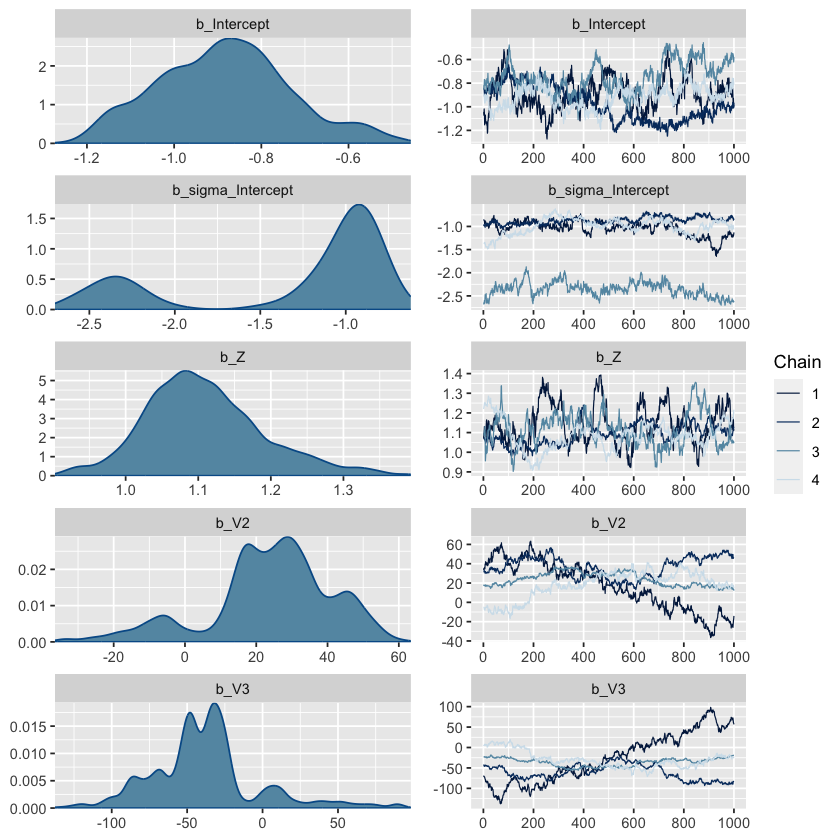

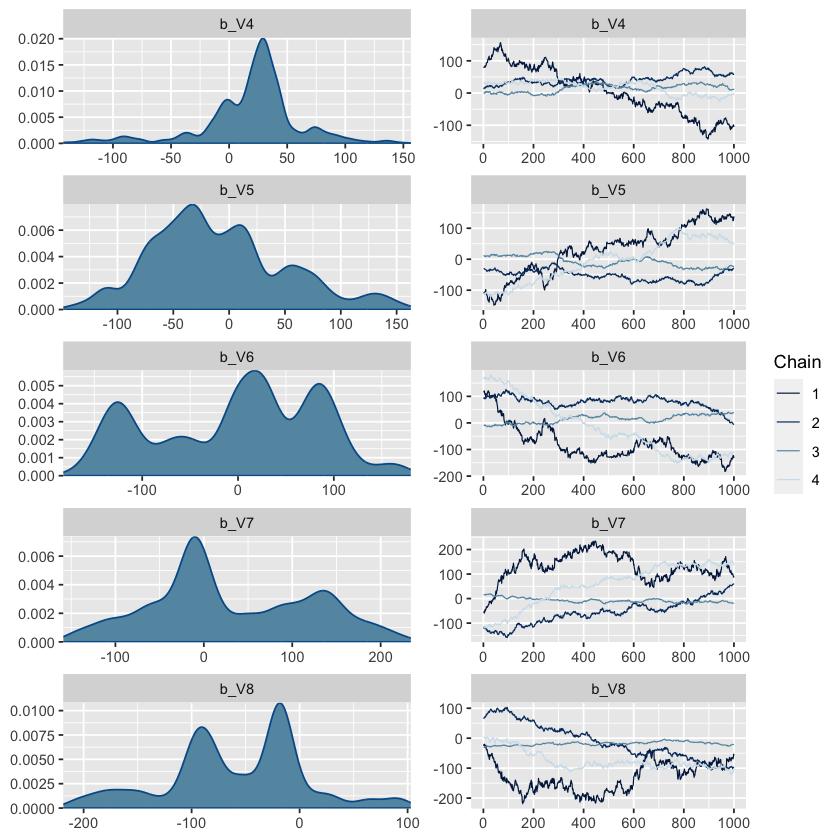

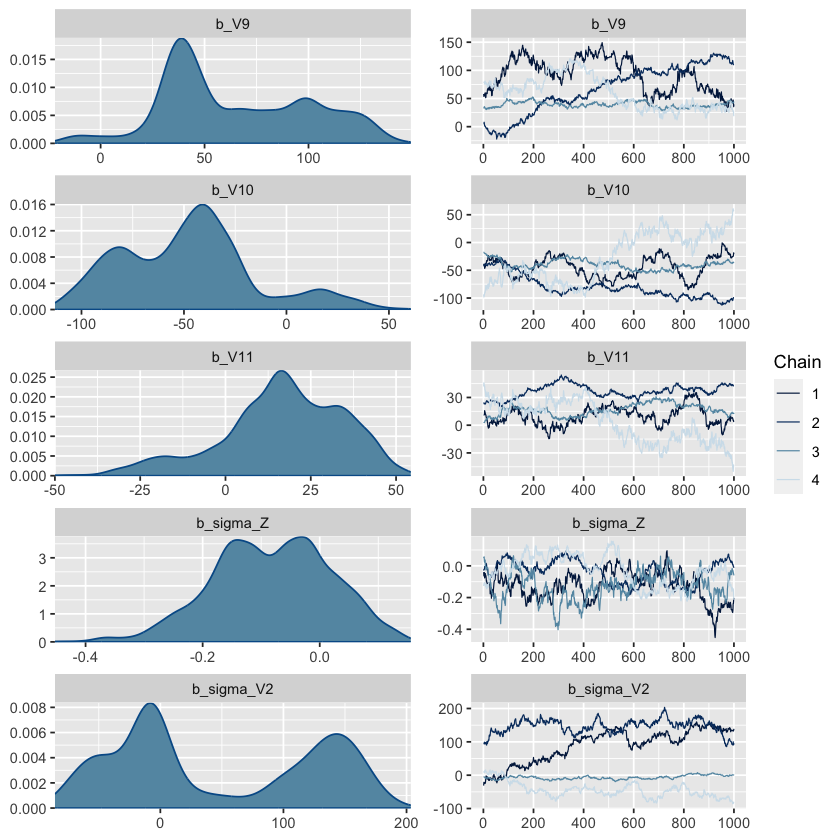

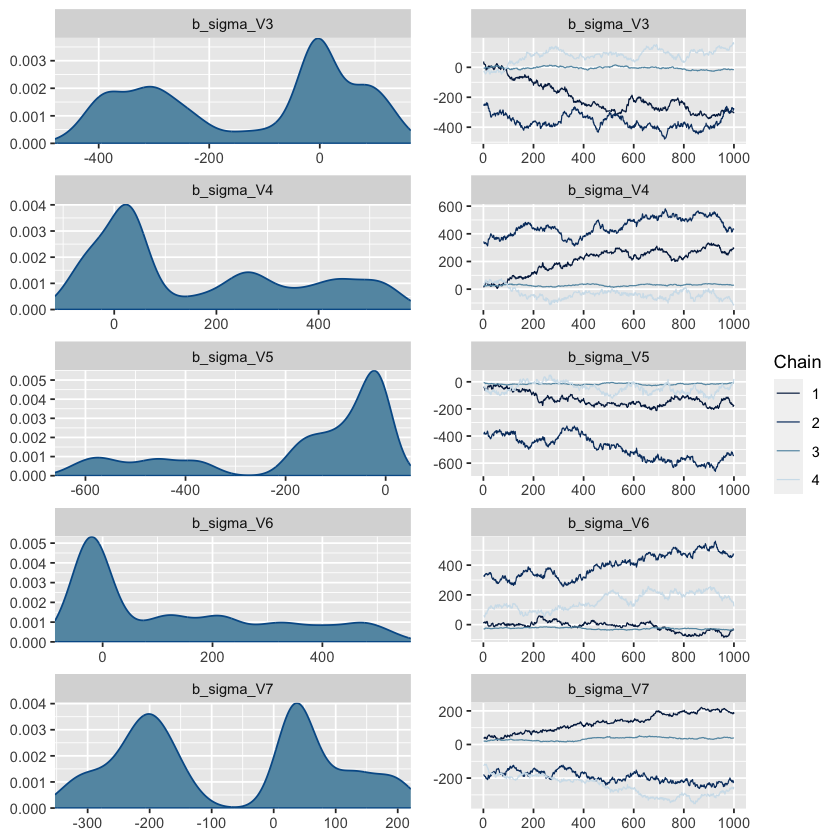

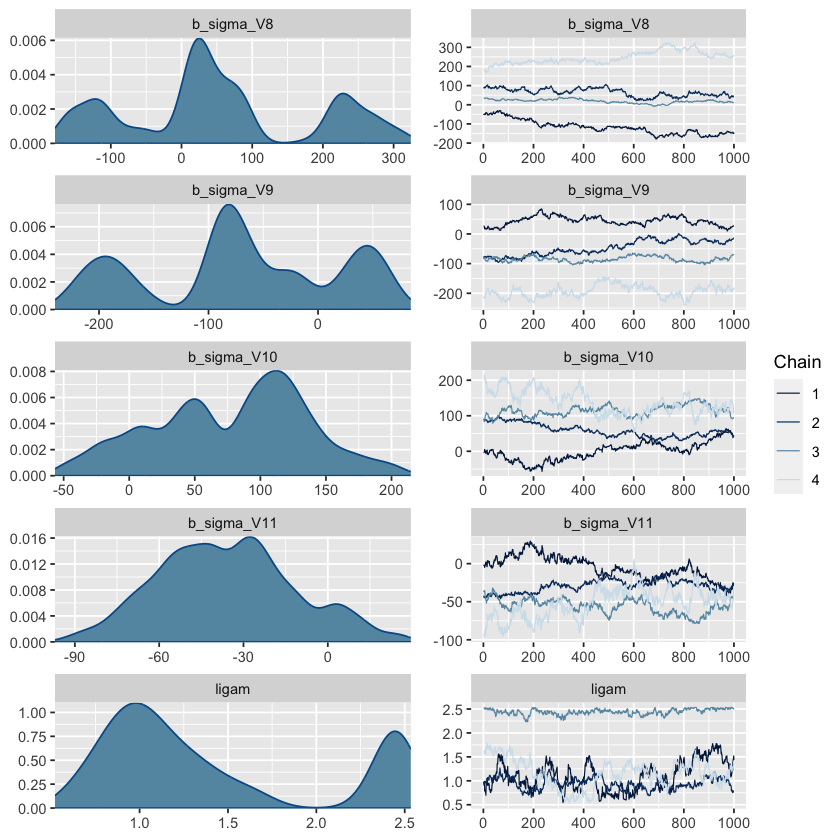

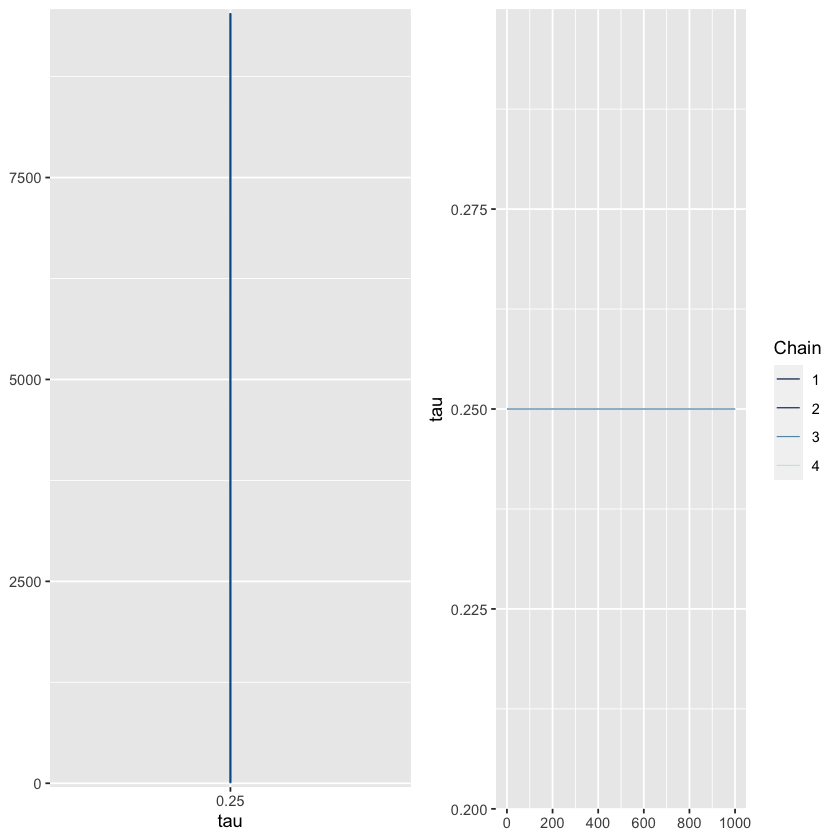

In [57]:
plot(q25)

Warning message:
"Argument 'pars' is deprecated. Please use 'variable' instead."


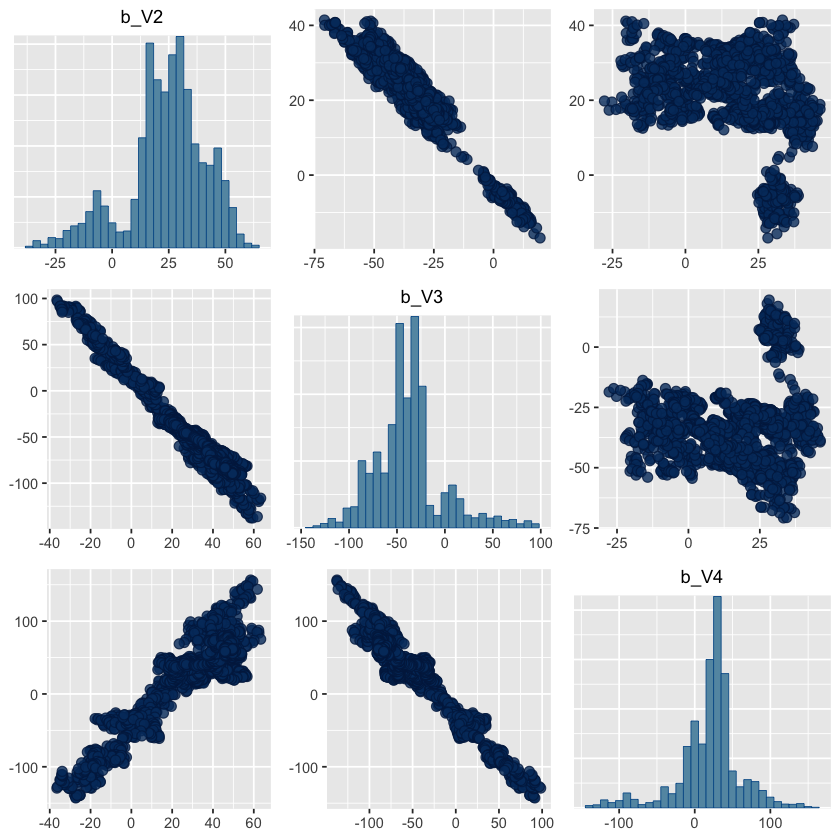

In [59]:
pairs(q25, pars = c("b_V2", "b_V3", "b_V4"))

In [64]:
prior_summary(q25)

prior                   class     coef group resp dpar  nlpar
1  student_t(3, -0.3, 2.5) Intercept                            
2  student_t(3, 0, 2.5)    Intercept                 sigma      
3                          b                                    
4                          b         V10                        
5                          b         V11                        
6                          b         V2                         
7                          b         V3                         
8                          b         V4                         
9                          b         V5                         
10                         b         V6                         
11                         b         V7                         
12                         b         V8                         
13                         b         V9                         
14                         b         Z                          
15                         b                         sigma      
16                         b         V10             sigma      
17                         b         V11             sigma      
18                         b         V2              sigma      
19                         b         V3              sigma      
20                         b         V4              sigma      
21                         b         V5              sigma      
22                         b         V6              sigma      
23                         b         V7              sigma      
24                         b         V8              sigma      
25                         b         V9              sigma      
26                         b         Z               sigma      
27                         ligam                                
   lb                ub               source 
1                                     default
2                                     default
3                                     default
4                                     default
5                                     default
6                                     default
7                                     default
8                                     default
9                                     default
10                                    default
11                                    default
12                                    default
13                                    default
14                                    default
15                                    default
16                                    default
17                                    default
18                                    default
19                                    default
20                                    default
21                                    default
22                                    default
23                                    default
24                                    default
25                                    default
26                                    default
27 -0.38918353755075 2.87231613469652 default

In [13]:
priors <- c(
    prior(normal(0, 1), class = b, coef = Z),
    prior(normal(0, 1), class = b, coef = V2),
    prior(normal(0, 1), class = b, coef = V3),
    prior(normal(0, 1), class = b, coef = V4),
    prior(normal(0, 1), class = b, coef = V5),
    prior(normal(0, 1), class = b, coef = V6),
    prior(normal(0, 1), class = b, coef = V7),
    prior(normal(0, 1), class = b, coef = V8),
    prior(normal(0, 1), class = b, coef = V9),
    prior(normal(0, 1), class = b, coef = V10),
    prior(normal(0, 1), class = b, coef = V11),
    prior(normal(0, 1), class = b, coef = Z, dpar = sigma),
    prior(normal(0, .1), class = b, coef = V2, dpar = sigma),
    prior(normal(0, .1), class = b, coef = V3, dpar = sigma),
    prior(normal(0, .1), class = b, coef = V4, dpar = sigma),
    prior(normal(0, .1), class = b, coef = V5, dpar = sigma),
    prior(normal(0, .1), class = b, coef = V6, dpar = sigma),
    prior(normal(0, .1), class = b, coef = V7, dpar = sigma),
    prior(normal(0, .1), class = b, coef = V8, dpar = sigma),
    prior(normal(0, .1), class = b, coef = V9, dpar = sigma),
    prior(normal(0, .1), class = b, coef = V10, dpar = sigma),
    prior(normal(0, .1), class = b, coef = V11, dpar = sigma)
)

In [14]:
q25 <- brm(formula, data = data, family = GAL2, stanvars = stanvars2, 
chains = 4, iter = 2000, control = list(adapt_delta = 0.99), cores = 4, seed = 123, prior = priors)

Compiling Stan program...

Start sampling



In [73]:
summary(q25)

Warning message:
"There were 873 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"


 Family: GAL2 
  Links: mu = identity; sigma = log; ligam = identity; tau = identity 
Formula: Y ~ Z + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11 
         sigma ~ Z + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11
         tau = 0.25
   Data: data (Number of observations: 100) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
                Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept          -0.88      0.13    -1.13    -0.63 1.00     3649     2472
sigma_Intercept    -1.00      0.15    -1.33    -0.73 1.00     1501     2474
Z                   1.05      0.12     0.81     1.28 1.00     2239     1896
V2                  0.10      0.69    -1.27     1.48 1.00     1962     1885
V3                  0.00      0.82    -1.58     1.64 1.00     2240     2570
V4                  0.02      0.78    -1.53     1.50 1.00     2440     2776
V5                  0.03      0.75    -1.43

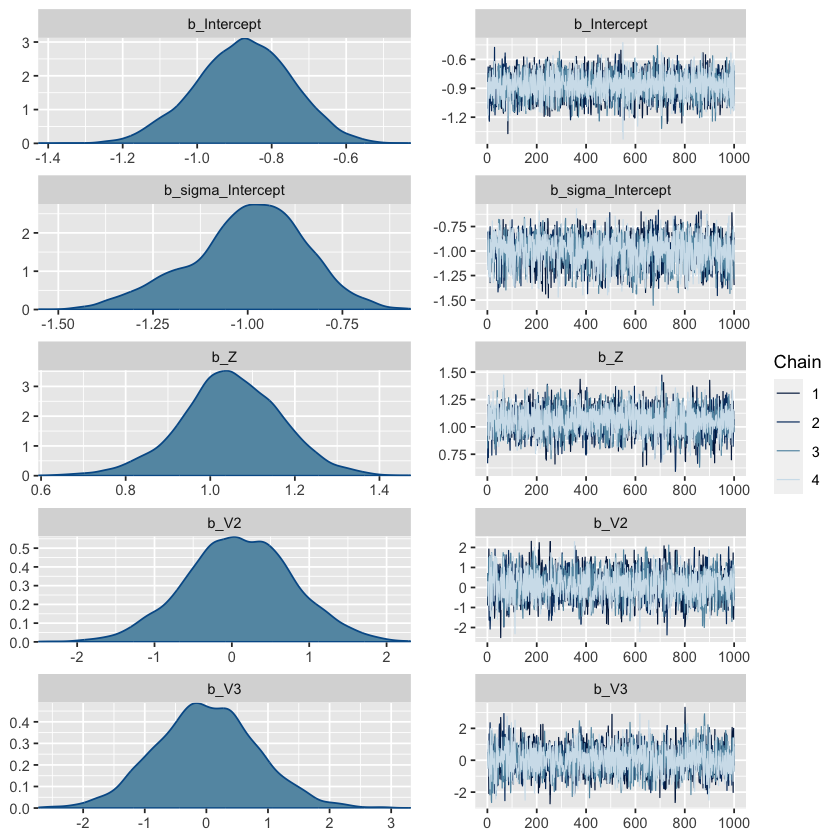

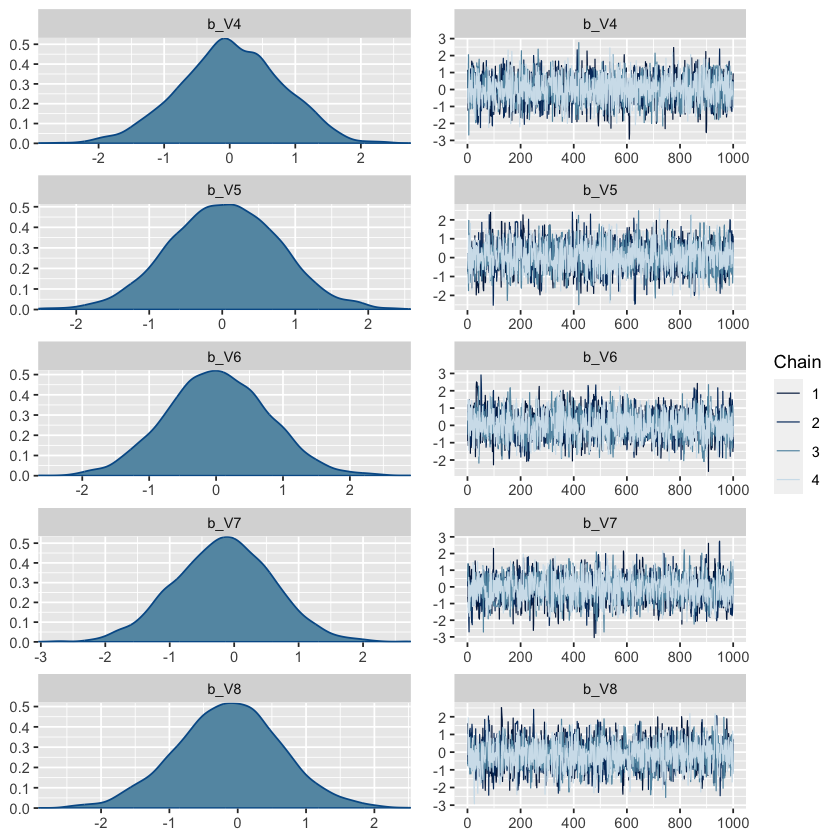

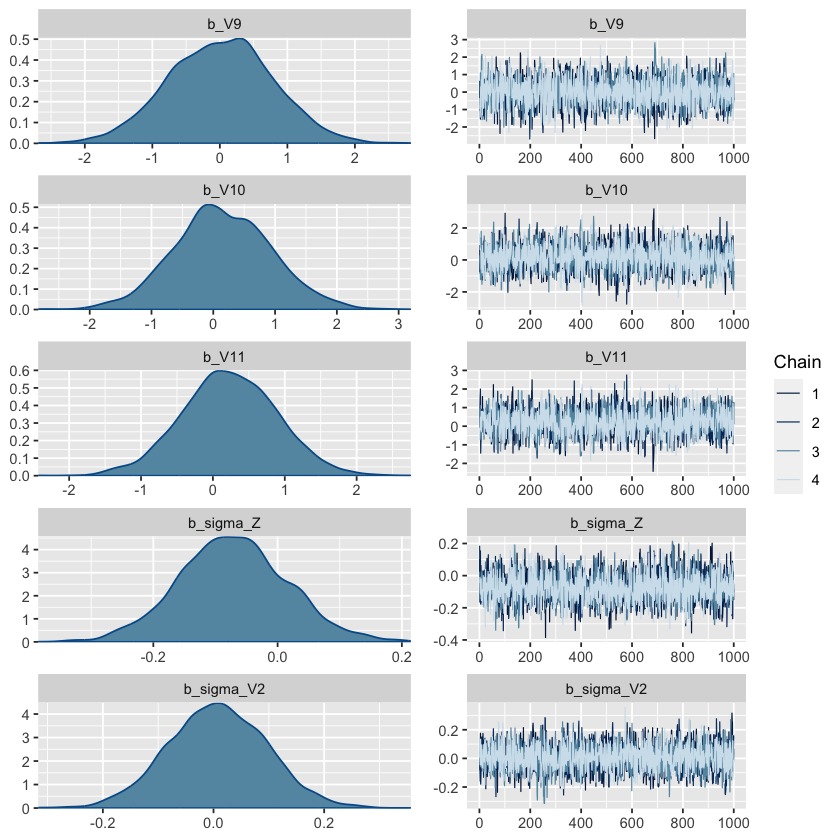

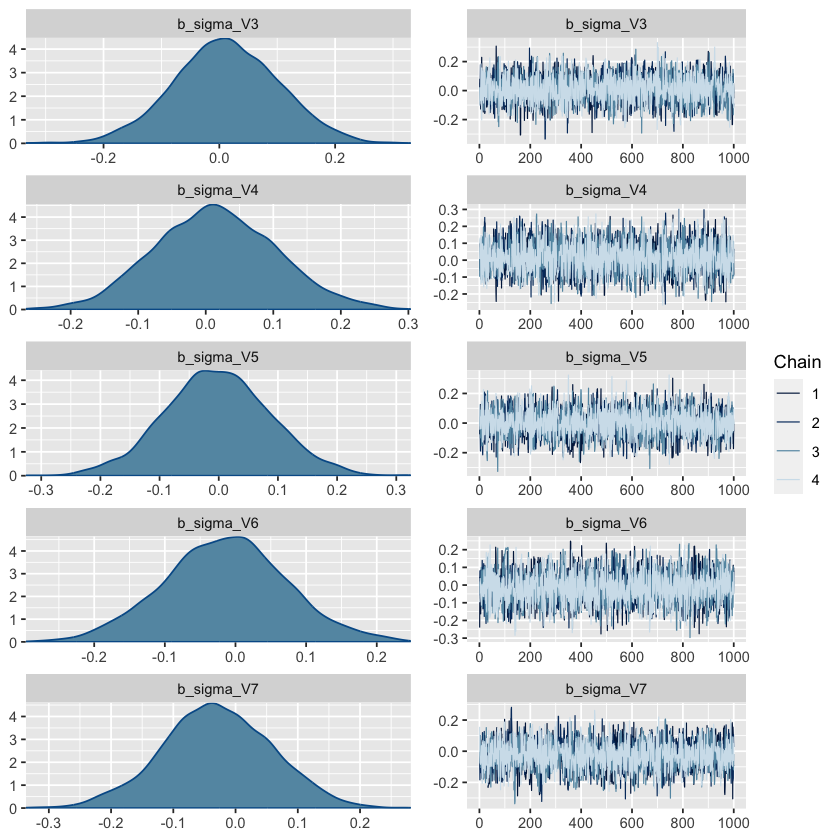

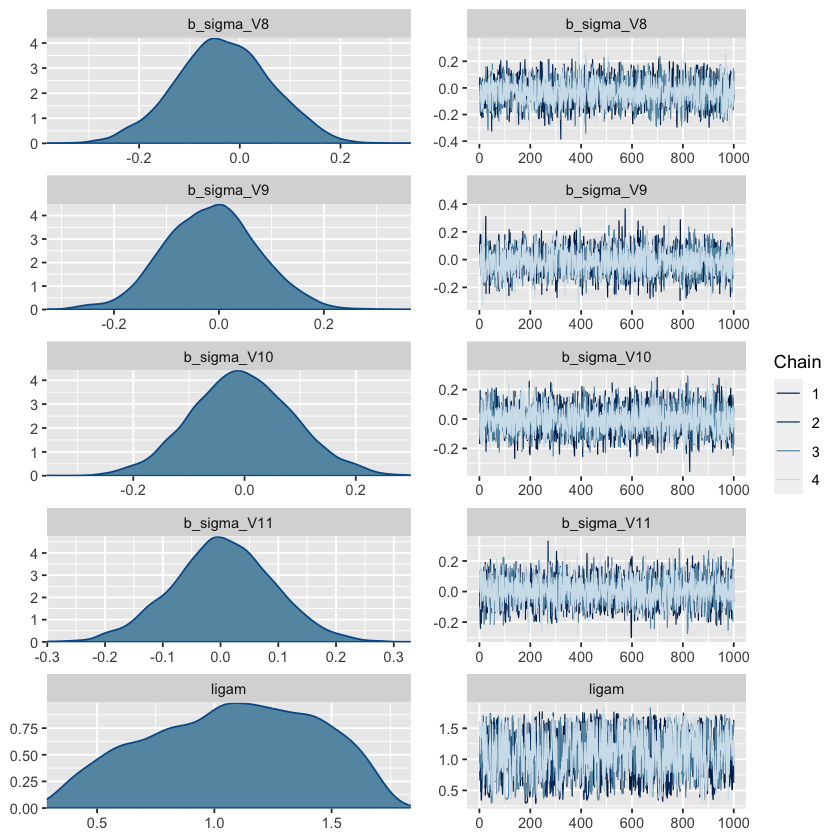

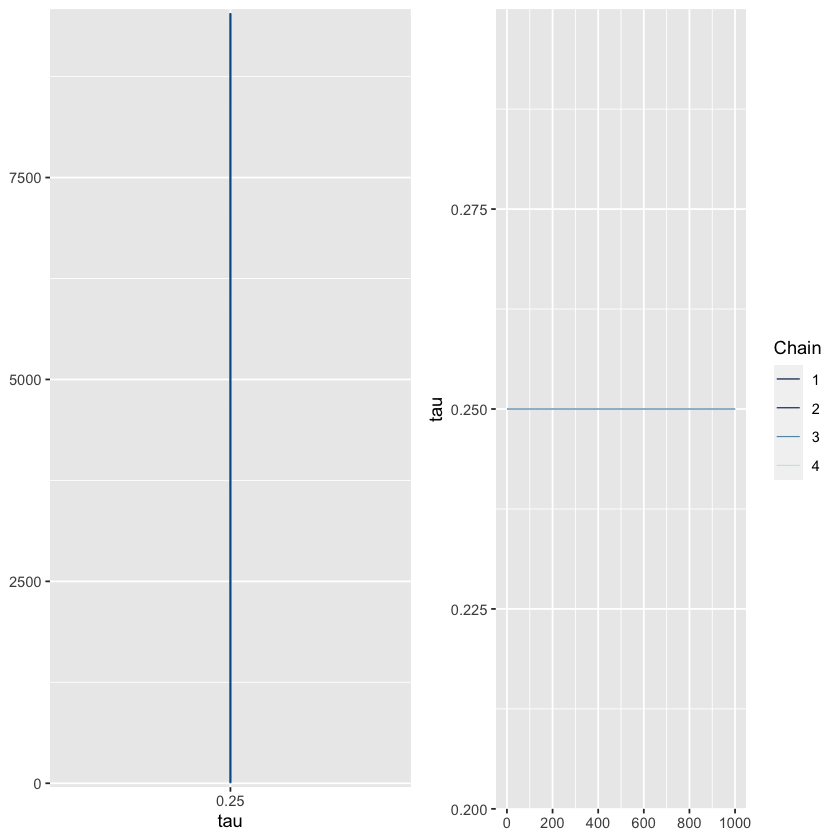

In [74]:
plot(q25)

Warning message:
"Argument 'pars' is deprecated. Please use 'variable' instead."


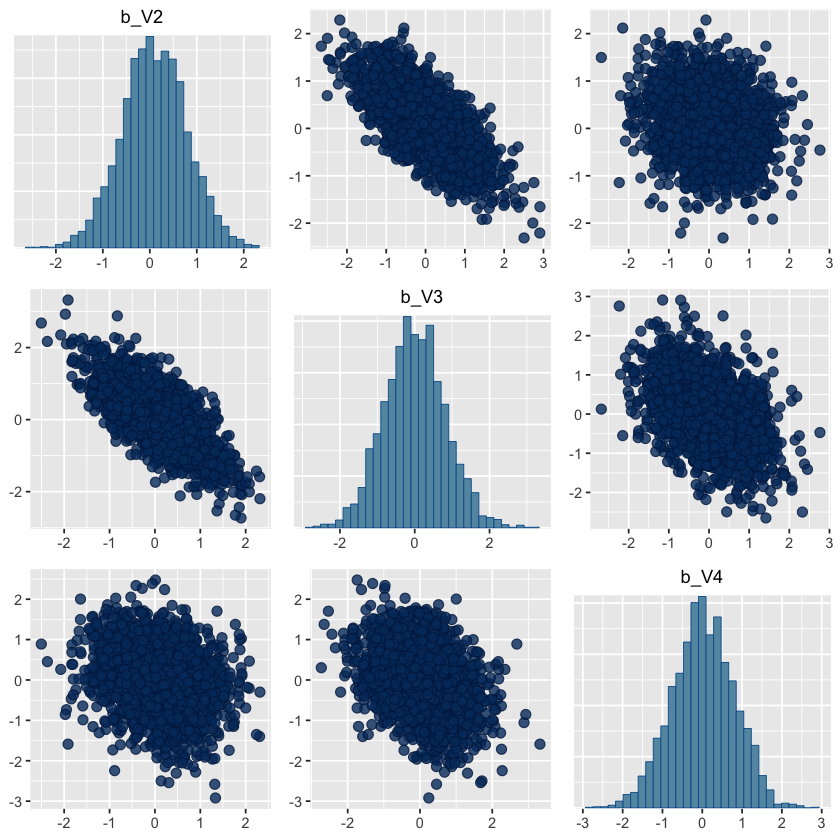

In [75]:
pairs(q25, pars = c("b_V2", "b_V3", "b_V4"))

In [76]:
summary(q25)$fixed

Warning message:
"There were 873 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"


Estimate     Est.Error  l-95% CI   u-95% CI   Rhat     Bulk_ESS
Intercept       -0.875268962 0.12859069 -1.1332957 -0.6338156 1.001164 3648.788
sigma_Intercept -0.999493524 0.15102625 -1.3262961 -0.7279833 1.002758 1500.699
Z                1.049105760 0.11882254  0.8054887  1.2819635 1.001215 2238.838
V2               0.100264343 0.69357972 -1.2667891  1.4785653 1.001293 1961.525
V3               0.004743008 0.82171104 -1.5763568  1.6443580 1.001035 2239.780
V4               0.020520398 0.78334777 -1.5263102  1.4978912 1.001089 2440.239
V5               0.033673827 0.75098109 -1.4319766  1.4947596 1.000718 1758.037
V6               0.023172160 0.75703780 -1.4260604  1.5113050 1.002153 1916.670
V7              -0.159080855 0.75801370 -1.6671755  1.3114933 1.000709 1940.824
V8              -0.131972658 0.76751019 -1.6574998  1.3819524 1.000928 2051.155
V9               0.014874825 0.77107351 -1.4923441  1.5080786 1.002408 2383.694
V10              0.155186597 0.79224893 -1.3858662  1.7361907 1.001598 1947.505
V11              0.231096982 0.66021017 -1.0825152  1.5222985 1.000889 2241.396
sigma_Z         -0.071216743 0.08705767 -0.2409924  0.1037426 1.002357 2331.701
sigma_V2         0.007460982 0.08876904 -0.1662164  0.1823588 1.000540 2910.426
sigma_V3         0.012024449 0.09071314 -0.1668026  0.1907422 1.001633 2810.543
sigma_V4         0.014891773 0.08977873 -0.1540206  0.1964268 1.000154 3293.962
sigma_V5        -0.001855705 0.08919186 -0.1792578  0.1775039 1.000632 3385.792
sigma_V6        -0.014334768 0.08628574 -0.1841565  0.1588243 1.000425 2306.897
sigma_V7        -0.029300651 0.08776073 -0.2050069  0.1415277 1.001067 2784.480
sigma_V8        -0.032113210 0.09406256 -0.2197534  0.1489236 1.002165 2765.540
sigma_V9        -0.014223068 0.08903194 -0.1858191  0.1615948 1.000913 2609.288
sigma_V10       -0.003306422 0.09085873 -0.1778141  0.1826198 1.001457 2637.029
sigma_V11        0.003934859 0.08704361 -0.1696882  0.1750434 1.003266 3050.841
                Tail_ESS
Intercept       2472.183
sigma_Intercept 2474.361
Z               1896.370
V2              1884.988
V3              2570.045
V4              2775.741
V5              1886.093
V6              1503.887
V7              2251.163
V8              1854.233
V9              2187.564
V10             2263.246
V11             2494.597
sigma_Z         2262.966
sigma_V2        2374.682
sigma_V3        2245.442
sigma_V4        2355.783
sigma_V5        2576.027
sigma_V6        1567.479
sigma_V7        2098.249
sigma_V8        2449.529
sigma_V9        2288.257
sigma_V10       2308.811
sigma_V11       2486.550

In [81]:
library(stargazer)
stargazer(summary(q25)$fixed[1:3, 1:4], digits = 3, summary = FALSE)


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Mon, Apr 17, 2023 - 23:25:09
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & Estimate & Est.Error & l-95\% CI & u-95\% CI \\ 
\hline \\[-1.8ex] 
Intercept & $$-$0.875$ & $0.129$ & $$-$1.133$ & $$-$0.634$ \\ 
sigma\_Intercept & $$-$0.999$ & $0.151$ & $$-$1.326$ & $$-$0.728$ \\ 
Z & $1.049$ & $0.119$ & $0.805$ & $1.282$ \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


In [83]:
plot(pp_check(q25))

Using 10 posterior draws for ppc type 'dens_overlay' by default.



ERROR: Error in get(out, family$env): object 'posterior_predict_GAL2' not found
